<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz
!pip install pymc3>=3.8

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [3]:
pm.__version__

'3.7'

In [4]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d2 = d[d.age > 18]
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
d2.head()

,height,weight,age,male,weight_c
0,151.765,47.825606,63.0,1,2.780064
1,139.700,36.485807,63.0,0,-8.559736
2,136.525,31.864838,65.0,0,-13.180705
3,156.845,53.041915,41.0,1,7.996372
4,145.415,41.276872,51.0,0,-3.768671


In [5]:
# 4.42
with pm.Model() as m_4_4_2:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [00:01<00:00, 1271.81it/s]


Text(0, 0.5, 'height')

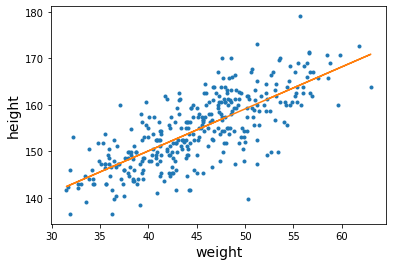

In [6]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_4_2['alpha'].mean() + trace_4_4_2['beta'].mean() * d2.weight_c)
plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14)


In [7]:
_ = pm.traceplot(trace_4_4_2, var_names=["m", "b", "logs"])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


AttributeError: ignored